<table style="width: 100%">
    <tr style="background: #ffffff">
        <td style="padding-top:25px;width: 180px"><img src="https://mci.edu/templates/mci/images/logo.svg" alt="Logo"></td>
        <td style="width: 100%">
            <div style="text-align:right; width: 100%; text-align:right"><font style="font-size:38px"><b>Data Science</b></font></div>
            <div style="padding-top:0px; width: 100%; text-align:right"><font size="4"><b>Bio Data-Science</b></font></div>
        </td>
    </tr>
</table>

---

# 5 Cross-Validation and Model Selection

In this session we revisit the penguin data set from last week. We still know, that there are no serious outliers, but some missing values. So we start by removing observations with missing values.



In [2]:
import seaborn as sns
import pandas as pd

penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## 5.1 Resampling / Cross Validation

In the first part, we will take the practical approach an cut a random test-set from the data and perform a k-fold cross-validation on the remaining data.


## Data preparation

Frist, we create binary dummy variables for species, island and sex and remove the original variables from the data set

In [3]:
penguins_cleaned = penguins.dropna()
penguins_cleaned

penguins_cleaned["isAdelie"] = False
penguins_cleaned["isGentoo"] = False
penguins_cleaned.loc[:]["isAdelie"] = penguins_cleaned["species"]=="Adelie"
penguins_cleaned.loc[:]["isGentoo"] = penguins_cleaned["species"]=="Gentoo"
penguins_cleaned["island"].unique()

penguins_cleaned["fromTorgersen"] = False
penguins_cleaned["fromBiscoe"] = False
penguins_cleaned.loc[:]["fromTorgersen"] = penguins_cleaned["island"]=="Torgersen"
penguins_cleaned.loc[:]["fromBiscoe"] = penguins_cleaned["island"]=="Biscoe"

penguins_cleaned["isFemale"] = penguins_cleaned["sex"]=="Female"
penguins_cleaned

penguins_cleaned.drop(["species", "island","sex"], axis = 1)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,isAdelie,isGentoo,fromTorgersen,fromBiscoe,isFemale
0,39.1,18.7,181.0,3750.0,False,False,False,False,False
1,39.5,17.4,186.0,3800.0,False,False,False,False,True
2,40.3,18.0,195.0,3250.0,False,False,False,False,True
4,36.7,19.3,193.0,3450.0,False,False,False,False,True
5,39.3,20.6,190.0,3650.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,False,False,False,False,True
340,46.8,14.3,215.0,4850.0,False,False,False,False,True
341,50.4,15.7,222.0,5750.0,False,False,False,False,False
342,45.2,14.8,212.0,5200.0,False,False,False,False,True


This gives us eight possible variables to use as predictors for the weight.

### Creating a test set

The sklearn model provides us [ready-to-use functions](https://scikit-learn.org/stable/modules/cross_validation.html) for splitting the data.

First, we use the ```train_test_split()``` function to create an hold-out test set from the original data. We pass the dataframe and test set size as the main parameters. We also ensure, that the data is suffled and set a random state (seed) for reproducibility (e.g., we always get the same results if we split the data randomly).

We are in the right segement, where we split the data in training (containing training and validation data) and test set.

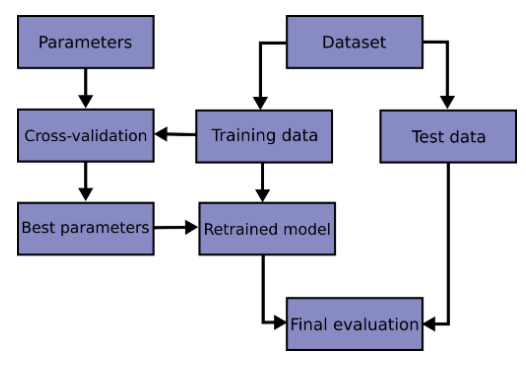

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# This returns two data frames  one for training and validation and one for testing
training_and_validation, test = train_test_split(penguins_cleaned, test_size=0.15, shuffle = True, random_state=1)

print("The original data has {} observations.".format(penguins_cleaned.shape[0]))
print("-- {} are in the training and validation set.".format(training_and_validation.shape[0]))
print("-- {} are in the test set.".format(test.shape[0]))

The original data has 333 observations.
-- 283 are in the training and validation set.
-- 50 are in the test set.


In [5]:
training_and_validation.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,isAdelie,isGentoo,fromTorgersen,fromBiscoe,isFemale
99,Adelie,Dream,43.2,18.5,192.0,4100.0,Male,False,False,False,False,False
34,Adelie,Dream,36.4,17.0,195.0,3325.0,Female,False,False,False,False,True
71,Adelie,Torgersen,39.7,18.4,190.0,3900.0,Male,False,False,False,False,False
265,Gentoo,Biscoe,43.6,13.9,217.0,4900.0,Female,False,False,False,False,True
330,Gentoo,Biscoe,50.5,15.2,216.0,5000.0,Female,False,False,False,False,True


In [6]:
test.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,isAdelie,isGentoo,fromTorgersen,fromBiscoe,isFemale
65,Adelie,Biscoe,41.6,18.0,192.0,3950.0,Male,False,False,False,False,False
276,Gentoo,Biscoe,43.8,13.9,208.0,4300.0,Female,False,False,False,False,True
186,Chinstrap,Dream,49.7,18.6,195.0,3600.0,Male,False,False,False,False,False
198,Chinstrap,Dream,50.1,17.9,190.0,3400.0,Female,False,False,False,False,True
293,Gentoo,Biscoe,46.5,14.8,217.0,5200.0,Female,False,False,False,False,True


### Implementing k-fold

Next, we define how the training (and validation) set will be split during cross-validation:

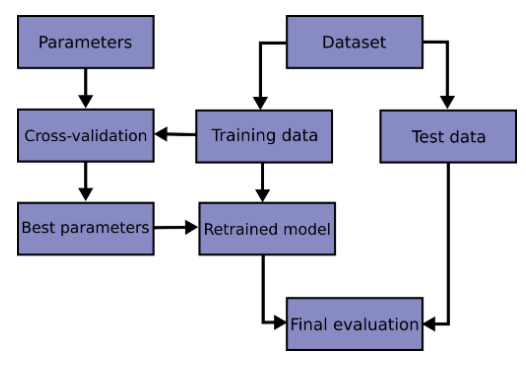

Here, we omit the shuffling, to ensure different data in each fold. In this way, it is easier to see how the data is split. Without any randomness, we also do not have to set a seed.

Be aware, that this function does not return the DataFrame itself (like the function above), but the indicies of the training and validation set in the original data set (`training_and_validation`).

In [7]:
from sklearn.model_selection import KFold

# Creating the k-fold object with 5 folds
kf = KFold(n_splits=5)

# Implementing a counter
fold = 0

# looping over the splits of the k-fold object
for train_index, validation_index in kf.split(training_and_validation):

    fold = fold + 1

    print("This is fold  number {}. We stored the indicies of the training and validation set of the fold.".format(fold))
    print("The following indicies are in the validation set:")
    print(validation_index)
    print("\n")



This is fold  number 1. We stored the indicies of the training and validation set of the fold.
The following indicies are in the validation set:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]


This is fold  number 2. We stored the indicies of the training and validation set of the fold.
The following indicies are in the validation set:
[ 57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113]


This is fold  number 3. We stored the indicies of the training and validation set of the fold.
The following indicies are in the validation set:
[114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 15

## Bringing it all together

Next, we use the cross-validation sets, we created to train different models to find the best parameters. We start with an simple example, where we only analyze one model with all possible predictors.

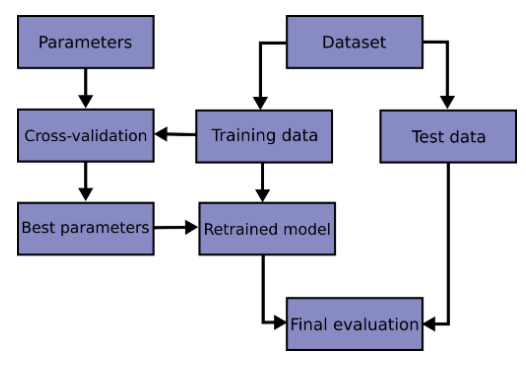

We start by creating a data structre, to store the results of the experiment. For each fold and earch model, we want to store the data set, we used, the error we made, the predictors and the number of predictors. We also want to store an individual number for each model.

In [8]:
# Here we just prepare the data structure to store the results
import pandas as pd

columns=["fold", "data_set", "MSE", "predictors" ,"number_of_predictors", "model_number"]

### Training with Cross-Validation

In this simple example, we only use one model with the predictors `['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']` and compare it's accuracy on the five folds of the cross-validation


In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# The kFold Split
kf = KFold(n_splits=5)

# An empty list to store the results
results = []

# The full list of possible predictors
list_of_predictors = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']

# We call the first fold 0 and the first model 1
# We will increment this in the loop
fold = 0
model_number = 1

# Loop over the five fold, we created
for train_index, validation_index in kf.split(training_and_validation):

    # for each fold
    # count the fold
    fold = fold + 1

    # Defining the predicted variable y and predictor X based on the indices
    X_train = training_and_validation.iloc[train_index][list_of_predictors]
    y_train = training_and_validation.iloc[train_index][["body_mass_g"]]


    # Define, that we want to take a linear regression as a model f
    reg = LinearRegression()

    # Fitting Simple Linear Regression to the test set
    reg.fit(X_train, y_train)

    # Make prediction on the validation set
    # We take the original training_and_validation DataFrame
    # Only the row that belong to the validation_index
    X_validate = training_and_validation.iloc[validation_index][list_of_predictors]

    y_validate = training_and_validation.iloc[validation_index][["body_mass_g"]]

    y_hat = reg.predict(X_validate)

    # Calculate the MSE
    mse = np.mean((y_validate.to_numpy()-y_hat)**2)

    # Add the results of the folds to the prior results
    results.append([fold, 'validation', mse, list_of_predictors, len(list_of_predictors), model_number])


In [10]:
# This are the predictors of the validation set of the last fold
X_validate.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,isAdelie,isGentoo,fromTorgersen,fromBiscoe,isFemale
172,42.4,17.3,181.0,False,False,False,False,True
89,38.9,18.8,190.0,False,False,False,False,True
161,51.3,19.9,198.0,False,False,False,False,False
287,49.5,16.2,229.0,False,False,False,False,False
132,36.8,18.5,193.0,False,False,False,False,True


In [11]:
# This are the actual values of the predicted variable of the validation set of the last fold
y_validate.head()

,body_mass_g
172,3600.0
89,3600.0
161,3700.0
287,5800.0
132,3500.0


In [12]:
# This are the predictions of the predicted variable of the validation set of the last fold
y_hat[:5]

array([[3131.25463801],
       [3346.84482522],
       [4162.79361989],
       [5665.88489406],
       [3481.31354622]])

### Evaluation on the Test Set

Next, we use the full training and validation set to retrain the same model again to make a prediction on the unseen test set:

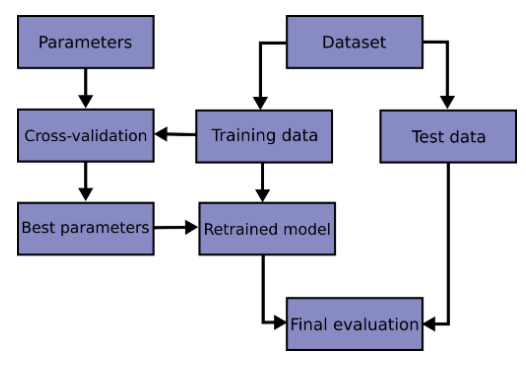



In [13]:
# Define, that we want to take a linear regression as a model f
reg = LinearRegression()

# Now, we take the full training and validation set
X_training_and_validation= training_and_validation[list_of_predictors]
y_training_and_validation = training_and_validation["body_mass_g"]


# Fitting Simple Linear Regression to the test set
reg.fit(X_training_and_validation, y_training_and_validation)

# Make prediction on the test set
X_test = test[list_of_predictors]
y_test = test["body_mass_g"]
y_hat = reg.predict(X_test)

mse = np.mean((y_test-y_hat)**2)

results.append([0, 'test', mse, list_of_predictors, len(list_of_predictors), model_number])

Finally, we create a data set from our lists of results.

The table shows the results of all our experiments (5 folds during model selection and the final error on the test set). For the simple model we looked at (having eight predictors) we see the mean squared error ($MSE$) on all the sets.

In [14]:
df_results = pd.DataFrame(columns=columns, data = results)
df_results

,fold,data_set,MSE,predictors,number_of_predictors,model_number
0,1,validation,141557.844470,"[bill_length_mm, bill_depth_mm, flipper_length...",8,1
1,2,validation,119653.773012,"[bill_length_mm, bill_depth_mm, flipper_length...",8,1
2,3,validation,115086.644029,"[bill_length_mm, bill_depth_mm, flipper_length...",8,1
3,4,validation,112185.069050,"[bill_length_mm, bill_depth_mm, flipper_length...",8,1
4,5,validation,84827.250523,"[bill_length_mm, bill_depth_mm, flipper_length...",8,1
5,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",8,1


### Visualization of the results

As to be be expected, we observe some variance in the $MSE$ on the validation sets of the cross-validation. The test-set error is close to the average error of the cross validation runs.

<Axes: xlabel='data_set', ylabel='MSE'>

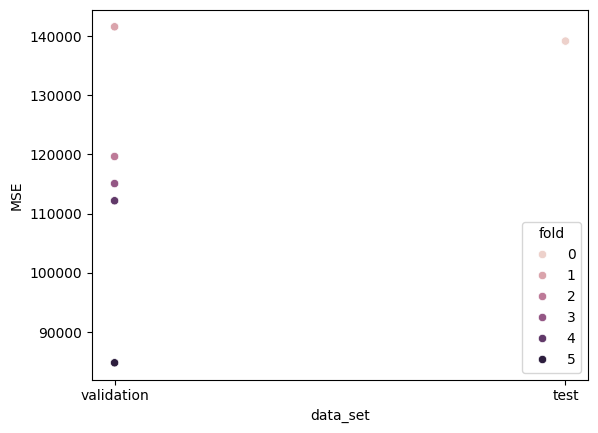

In [15]:
import seaborn as sns

sns.scatterplot(data=df_results, x="data_set", y="MSE", hue = "fold")

# 🏁 Recap

- If you have finished the tasks and have no questions, place the green card on top.
- If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.

![](https://www.lokalinfo.ch/fileadmin/news_import/image003_03.jpg)

## 🏆 Case Study I

Perform a full best subset selection to find a good model with a 5-fold cross validation.
- What is the best model's average $MSE$?
- What are the best model's predictors?
- Compare all the models You tested on the test set after training them on the full training and validation set. Does Your chosen model outperform all others?


Almost all the the code is prepare for You. The next cell creates a list of all possible predictor combinations (`list_of_all_predictor_combinations`).

Later, You will have to create one model for each predictor combinations in `list_of_all_predictor_combinations`.


In [16]:
# Hint: Itertools allows you to calculate a possible subsets
import itertools

list_of_all_predictors = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']

list_of_all_predictor_combinations = []
model_number = 0

for L in range(0, len(list_of_all_predictors)+1):
    for subset in itertools.combinations(list_of_all_predictors, L):
        list_of_current_predictors = list(subset)
        #print(list_of_current_predictors)
        list_of_all_predictor_combinations.append(list_of_current_predictors)
        model_number = model_number + 1

list_of_all_predictor_combinations.pop(0)


[]

In [17]:
# Now we have a list of all possible combinations of predictors
list_of_all_predictor_combinations

[['bill_length_mm'],
 ['bill_depth_mm'],
 ['flipper_length_mm'],
 ['isAdelie'],
 ['isGentoo'],
 ['fromTorgersen'],
 ['fromBiscoe'],
 ['isFemale'],
 ['bill_length_mm', 'bill_depth_mm'],
 ['bill_length_mm', 'flipper_length_mm'],
 ['bill_length_mm', 'isAdelie'],
 ['bill_length_mm', 'isGentoo'],
 ['bill_length_mm', 'fromTorgersen'],
 ['bill_length_mm', 'fromBiscoe'],
 ['bill_length_mm', 'isFemale'],
 ['bill_depth_mm', 'flipper_length_mm'],
 ['bill_depth_mm', 'isAdelie'],
 ['bill_depth_mm', 'isGentoo'],
 ['bill_depth_mm', 'fromTorgersen'],
 ['bill_depth_mm', 'fromBiscoe'],
 ['bill_depth_mm', 'isFemale'],
 ['flipper_length_mm', 'isAdelie'],
 ['flipper_length_mm', 'isGentoo'],
 ['flipper_length_mm', 'fromTorgersen'],
 ['flipper_length_mm', 'fromBiscoe'],
 ['flipper_length_mm', 'isFemale'],
 ['isAdelie', 'isGentoo'],
 ['isAdelie', 'fromTorgersen'],
 ['isAdelie', 'fromBiscoe'],
 ['isAdelie', 'isFemale'],
 ['isGentoo', 'fromTorgersen'],
 ['isGentoo', 'fromBiscoe'],
 ['isGentoo', 'isFemale'],
 ['

In [18]:
# For instance, this is a list with the names of all predictors in a simple model, that only includes bill depth as a predictor
list_of_all_predictor_combinations[1]

['bill_depth_mm']

In [19]:
# For instance, this is a list with the names of all predictors in a more complicated model, that only includes all possible predictors
list_of_all_predictor_combinations[-1]

['bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'isAdelie',
 'isGentoo',
 'fromTorgersen',
 'fromBiscoe',
 'isFemale']

### ✍️ Perform Cross Validation

Here You can adjust the code from above (The cell under **Training with Cross-Validation**). Change the code which was copied from above. You only have to change a few lines!

- All You have to do is have to integrate a second `for`-loop that includes the cross-validation loop and loops over the `list_of_all_predictor_combinations`. Doing so, it should changes the `list_of_predictors` to create different models.
- Don't forget to increment the model number by each passing of the loop. You also might have to change the position, where the `fold` is reset to `0`.

In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# The kFold Split
kf = KFold(n_splits=5)

# An empty list to store the results
results = []

# The full list of possible predictors
list_of_predictors = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']

# We call the first fold 0 and the first model 1
# We will increment this in the loop
"""
Check whether this is the right place to define the fold and model number
"""

fold = 0
model_number = 1


"""
Originally, we only had one model, that included all predictors list_of_predictors
Now, we loop over all possible combinations of predictors in list_of_all_predictor_combinations
Within this loop, we loop over the five folds
"""
# Loop over the five fold, we created
for train_index, validation_index in kf.split(training_and_validation):

    # for each fold
    # count the fold
    fold = fold + 1

    # Defining the predicted variable y and predictor X based on the indices
    X_train = training_and_validation.iloc[train_index][list_of_predictors]
    y_train = training_and_validation.iloc[train_index][["body_mass_g"]]


    # Define, that we want to take a linear regression as a model f
    reg = LinearRegression()

    # Fitting Simple Linear Regression to the test set
    reg.fit(X_train, y_train)

    # Make prediction on the validation set
    # We take the original training_and_validation DataFrame
    # Only the row that belong to the validation_index
    X_validate = training_and_validation.iloc[validation_index][list_of_predictors]

    y_validate = training_and_validation.iloc[validation_index][["body_mass_g"]]

    y_hat = reg.predict(X_validate)

    # Calculate the MSE
    mse = np.mean((y_validate.to_numpy()-y_hat)**2)

    # Add the results of the folds to the prior results
    results.append([fold, 'validation', mse, list_of_predictors, len(list_of_predictors), model_number])

In [21]:


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# The kFold Split
kf = KFold(n_splits=5)

# An empty list to store the results
results = []

# The full list of possible predictors
list_of_predictors = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']

# We call the first fold 0 and the first model 1
# We will increment this in the loop
fold = 0
model_number = 0

for  list_of_predictors in list_of_all_predictor_combinations:
    model_number = model_number + 1
    fold = 0
    # Loop over the five fold, we created
    for train_index, validation_index in kf.split(training_and_validation):

        # for each fold
        # count the fold
        fold = fold + 1

        # Defining the predicted variable y and predictor X based on the indices
        X_train = training_and_validation.iloc[train_index][list_of_predictors]
        y_train = training_and_validation.iloc[train_index][["body_mass_g"]]


        # Define, that we want to take a linear regression as a model f
        reg = LinearRegression()

        # Fitting Simple Linear Regression to the test set
        reg.fit(X_train, y_train)

        # Make prediction on the validation set
        # We take the original training_and_validation DataFrame
        # Only the row that belong to the validation_index
        X_validate = training_and_validation.iloc[validation_index][list_of_predictors]

        y_validate = training_and_validation.iloc[validation_index][["body_mass_g"]]

        y_hat = reg.predict(X_validate)

        # Calculate the MSE
        mse = np.mean((y_validate-y_hat)**2)

        # Add the results of the folds to the prior results
        results.append([fold, 'validation', mse, list_of_predictors, len(list_of_predictors), model_number])


In [22]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# The kFold Split
kf = KFold(n_splits=5)

# An empty list to store the results
results = []

# The full list of possible predictors
list_of_predictors = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']

# We call the first fold 0 and the first model 1
# We will increment this in the loop


model_number = 0 # Count the model number up

for list_of_predictors in list_of_all_predictor_combinations:

    model_number = model_number + 1
    fold = 0

    # Loop over the five fold, we created
    for train_index, validation_index in kf.split(training_and_validation):


        # for each fold
        # count the fold
        fold = fold + 1

        # Defining the predicted variable y and predictor X based on the indices
        X_train = training_and_validation.iloc[train_index][list_of_predictors]
        y_train = training_and_validation.iloc[train_index][["body_mass_g"]]


        # Define, that we want to take a linear regression as a model f
        reg = LinearRegression()

        # Fitting Simple Linear Regression to the test set
        reg.fit(X_train, y_train)

        # Make prediction on the validation set
        # We take the original training_and_validation DataFrame
        # Only the row that belong to the validation_index
        X_validate = training_and_validation.iloc[validation_index][list_of_predictors]

        y_validate = training_and_validation.iloc[validation_index][["body_mass_g"]]

        y_hat = reg.predict(X_validate)

        # Calculate the MSE
        mse = np.mean((y_validate-y_hat)**2)[0]

        # Add the results of the folds to the prior results
        results.append([fold, 'validation', mse, list_of_predictors, len(list_of_predictors), model_number])


IndexError: invalid index to scalar variable.

In [ ]:
# The resulting dataframe should store the data for all cross-validation folds and all models
df_results = pd.DataFrame(columns=columns, data = results)
df_results

,fold,data_set,MSE,predictors,number_of_predictors,model_number
0,1,validation,528425.308194,[bill_length_mm],1,1
1,2,validation,422437.574449,[bill_length_mm],1,1
2,3,validation,426538.156170,[bill_length_mm],1,1
3,4,validation,358419.906671,[bill_length_mm],1,1
4,5,validation,323478.395749,[bill_length_mm],1,1
...,...,...,...,...,...,...
1270,1,validation,141557.844470,"[bill_length_mm, bill_depth_mm, flipper_length...",8,255
1271,2,validation,119653.773012,"[bill_length_mm, bill_depth_mm, flipper_length...",8,255
1272,3,validation,115086.644029,"[bill_length_mm, bill_depth_mm, flipper_length...",8,255
1273,4,validation,112185.069050,"[bill_length_mm, bill_depth_mm, flipper_length...",8,255


<Axes: xlabel='number_of_predictors', ylabel='MSE'>

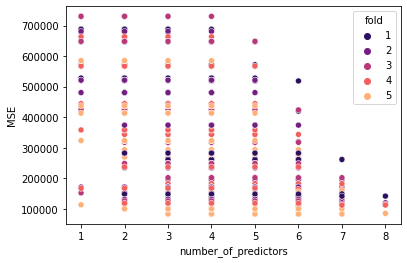

In [ ]:
# With this plot You can see how the number of predictors influences the models in-sample accuracy
import seaborn as sns

sns.scatterplot(data=df_results, x="number_of_predictors", y="MSE", hue = "fold", palette=sns.color_palette("magma", 5))

<Axes: xlabel='number_of_predictors', ylabel='MSE'>

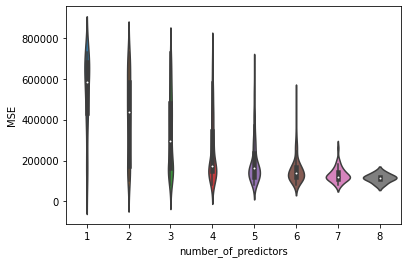

In [ ]:
# This is just another way to visualize it
import seaborn as sns

sns.violinplot(data=df_results, x="number_of_predictors", y="MSE")

### Model selection

- Which Model number has the best average $MSE$ on in the cross-validation?
- What are its predictor variables?

In [ ]:
mean_results = df_results.groupby("model_number").mean("MSE")
mean_results.drop(columns=["fold"], inplace=True)

In [ ]:
# Sort the Model by MSE
mean_results.sort_values("MSE")

,MSE,number_of_predictors
model_number,,
137,114023.561386,4.0
131,114023.561386,4.0
134,114023.561386,4.0
136,114023.561386,4.0
62,114023.561386,3.0
...,...,...
83,669923.888548,3.0
32,669923.888548,2.0
34,669923.888548,2.0


### ✍️ Find the parameters of the best model


In [ ]:
#@title ❓ Click `Show code` in the code cell to show the solution. { display-mode: "form" }
df_results[df_results["model_number"]==221]["predictors"][1100]

['bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'isAdelie',
 'isGentoo',
 'isFemale']

# 🏁 Recap

- If you have finished the tasks and have no questions, place the green card on top.
- If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.

![](https://www.lokalinfo.ch/fileadmin/news_import/image003_03.jpg)

### Check on Test Set

Finally, we can see, whether out selection makes sense on the test set:

In [ ]:
# We retrain all models on the full training and validation set
# We will use the test set to evaluate the model
results = []
model_number = 0

for list_of_predictors in list_of_all_predictor_combinations:
        
        model_number = model_number + 1
        
        if len(list_of_predictors) != 0:

          # Defining the predicted variable y and predictor X

          X_training_and_validation = training_and_validation[list_of_predictors]
          y_training_and_validation = training_and_validation["body_mass_g"]

          # Define, that we want to take a linear regression as a model f
          reg = LinearRegression()

          # Fitting Simple Linear Regression to the test set
          reg.fit(X_training_and_validation, y_training_and_validation)


          X_test = test[list_of_predictors]
          y_test = test["body_mass_g"]
          y_hat = reg.predict(X_test)

          mse = np.mean((y_test-y_hat)**2)

          results.append([0, 'test', mse, list_of_predictors, len(list_of_predictors), model_number])

In [ ]:
df_results = pd.DataFrame(columns=columns, data = results)
df_results

,fold,data_set,MSE,predictors,number_of_predictors,model_number
0,0,test,499298.452851,[bill_length_mm],1,1
1,0,test,480027.025768,[bill_depth_mm],1,2
2,0,test,159455.784150,[flipper_length_mm],1,3
3,0,test,522224.303431,[isAdelie],1,4
4,0,test,522224.303431,[isGentoo],1,5
...,...,...,...,...,...,...
250,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",7,251
251,0,test,252662.430455,"[bill_length_mm, bill_depth_mm, isAdelie, isGe...",7,252
252,0,test,152602.362250,"[bill_length_mm, flipper_length_mm, isAdelie, ...",7,253
253,0,test,139436.474717,"[bill_depth_mm, flipper_length_mm, isAdelie, i...",7,254


In [ ]:
df_results.sort_values("MSE").head(20)

,fold,data_set,MSE,predictors,number_of_predictors,model_number
96,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",4,97
220,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",6,221
222,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",6,223
223,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",6,224
225,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",6,226
226,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",6,227
227,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",6,228
165,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",5,166
168,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",5,169
170,0,test,139142.596001,"[bill_length_mm, bill_depth_mm, flipper_length...",5,171


In [ ]:
# We can see, that model 221 is the fourth best
# It also shows that the best model using all 8 variables

In [ ]:
df_results.sort_values("MSE").tail(5)

,fold,data_set,MSE,predictors,number_of_predictors,model_number
31,0,test,522224.303431,"[isGentoo, fromBiscoe]",2,32
30,0,test,522224.303431,"[isGentoo, fromTorgersen]",2,31
28,0,test,522224.303431,"[isAdelie, fromBiscoe]",2,29
85,0,test,522224.303431,"[isAdelie, fromTorgersen, fromBiscoe]",3,86
157,0,test,522224.303431,"[isAdelie, isGentoo, fromTorgersen, fromBiscoe]",4,158


We can take a closer look at this model, to see how it works. If we look at the parameters, we see that for instance being a female penguins decreases the predicted weight.

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('body_mass_g ~ bill_length_mm +bill_depth_mm + flipper_length_mm + isAdelie + fromTorgersen + fromBiscoe + isFemale + 1', data = training_and_validation)
results = model.fit()
print(results.summary())


NameError: name 'training_and_validation' is not defined

# 🏁 Recap

- If you have finished the tasks and have no questions, place the green card on top.
- If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.

![](https://www.lokalinfo.ch/fileadmin/news_import/image003_03.jpg)

## 5.2 Regularisation

Regularisation is an approach to replace the need for variable selection by changing the cost function of a linear regression model. In the example above, we tried a brute force approach to test all possible predictor combinations. This requires to train more than 200 models. The best model on the validation set contained all variables but `fromTorgersen` and `fromBiscoe` and had an test set MSE of $94549.835$. In this task, we try to beat this performance.

We start by loading and cleaning the data:

In [ ]:
import seaborn as sns
import pandas as pd

penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()
penguins

penguins_cleaned = penguins.dropna()
penguins_cleaned

penguins_cleaned["isAdelie"] = False
penguins_cleaned["isGentoo"] = False
penguins_cleaned.loc[:]["isAdelie"] = penguins_cleaned["species"]=="Adelie"
penguins_cleaned.loc[:]["isGentoo"] = penguins_cleaned["species"]=="Gentoo"
penguins_cleaned["island"].unique()

penguins_cleaned["fromTorgersen"] = False
penguins_cleaned["fromBiscoe"] = False
penguins_cleaned.loc[:]["fromTorgersen"] = penguins_cleaned["island"]=="Torgersen"
penguins_cleaned.loc[:]["fromBiscoe"] = penguins_cleaned["island"]=="Biscoe"

penguins_cleaned["isFemale"] = penguins_cleaned["sex"]=="Female"
penguins_cleaned

penguins_cleaned.drop(["species", "island","sex"], axis = 1)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

training_and_validation, test = train_test_split(penguins_cleaned, test_size=0.15, shuffle = True, random_state=1)

print("The original data has {} observations.".format(penguins_cleaned.shape[0]))
print("-- {} are in the training and validation set.".format(training_and_validation.shape[0]))
print("-- {} are in the test set.".format(test.shape[0]))

## Ridge Regression

As an alternative to the extensive search, we can use the regression model, with a regluarization term like the [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). This model expands the linear regression with a penalty term for large coefficents $\beta_i$:


$$RSS+\alpha \sum^p_{j=1}  \beta_j^2$$

- $\sum^p_{j=1}  \beta_j^2$ ... shrinkage penalty
- $\alpha$ ... tuning parameter (hyper parameter)
* note that the model will still contain all parameters

As Scikitlearn provides an implementation of the Ridge Regression, we do not have to change much in our previous code, but simply exchange the model.

We can pass the tuning parameter to the function in statmodels.
```reg = Ridge(alpha=1.0, random_state = 0)``` to try and $\alpha$ of $1$


In [ ]:
# Defining training and test set with all possible predictors
list_of_predictors = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'isAdelie', 'isGentoo','fromTorgersen',	'fromBiscoe',	'isFemale']
X_training_and_validation = training_and_validation[list_of_predictors]
y_training_and_validation = training_and_validation["body_mass_g"]

X_test = test[list_of_predictors]
y_test = test["body_mass_g"]

In [ ]:
# Training the Ridge Regression
## Note that we not use another model than with regular linear regression
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0, random_state = 0)
reg.fit(X_training_and_validation, y_training_and_validation)

In [ ]:
# Prediction and evaluation
# We see, that the ridge regression gives us good predictions, without the extensive search
# With an MSE of 96077, only four of our prior models performend better on the test set
y_hat = reg.predict(X_test)
mse = np.mean((y_test-y_hat)**2)
mse

As we did not scale the data, we see that the parameters of the predictors are on very different levels:

In [ ]:
# Print the Intercept:
print('intercept (beta_0):', reg.intercept_)

# Print the Slope:
print('slope (beta_i):', reg.coef_) 

# 🏁 Recap

- If you have finished the tasks and have no questions, place the green card on top.
- If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.

![](https://www.lokalinfo.ch/fileadmin/news_import/image003_03.jpg)

## 🏆 Case Study II

See if You can get a better test set result for the Ridge Regression using another alpha. Test all alphas in:

```
for alpha in np.linspace(0.0, 5, num=21):
  reg = Ridge(alpha=1.0, random_state = 0)
  <...>
```


In [ ]:
# Instead of printing alpha, train different models with changing alpha and print the test set  MSE
for alpha in np.linspace(0.0, 5, num=21):
  print(alpha)

In [ ]:
# Looping throug a possible set of hyper parameters alpha is what we call a grid search
# We observe, that in this case. The model without any penalty term (alpha = 0) is better than any other model
# This is exaclty the model number 257, with all predictors, also created in our extensive search

# 🏁 Recap

- If you have finished the tasks and have no questions, place the green card on top.
- If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.

![](https://www.lokalinfo.ch/fileadmin/news_import/image003_03.jpg)

## 🤓 Lasso Regression

In pratice, we should use the test and valdiation set, to  find the best parameter for $\alpha$, so that we have an untouched test set for the final evaluation. We could implement the cross validation, as we did for finding the best combination of predcitors.

Luckily, many sklearn functions already have this prepared for us. While [```Lasso```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) let's us select an alpha, if we use
[```LassoCV```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) sklearn automatically performs a cross validation during training to find the best alpha.


In [ ]:
# Training a Lasso Regression with automatic search fpr alpha
from sklearn.linear_model import LassoCV
# Here, we do not only decide for the random state bus also for the number of folds in the cross-validation
reg = LassoCV(cv=5, random_state=1)

reg.fit(X_training_and_validation, y_training_and_validation)

At the parameters we see, that the Lasso regression shrinks the parameters of some of the predictors down to `0`. This means, that they are not included in the model any more:

In [ ]:
# Print the Intercept:
print('intercept (beta_0):', reg.intercept_)

# Print the Slope:
print('slope (beta_i):', reg.coef_) 


In [ ]:
# Results of the Lasso Regression
y_hat = reg.predict(X_test)
mse = np.mean((y_test-y_hat)**2)
mse

### Comparison of the best models

If we compare, the parameters of the three models, we see that even if they all provide good results, the parameters they use are very different.

The Lasso Regression removes two other variables, than the feature selection we performed. We also see, that the parameters stay similar in magnitude, but are still very different. This shows, that more complicated flexible models (e.g., with many predictors) are harder to interpret.


|  | intercept | bill_length_mm | bill_depth_mm | flipper_length_mm | isAdelie | isGentoo | fromTorgersen | fromBiscoe | isFemale |
|---|---|---|---|---|---|---|---|---|---|
| Full set evaluation | -1228.8 | 16.3 | 62.7 | 16.4 | 228.1 | 1224.6 | 0 | 0 | -407.5 |
| Lasso | -1395.3 | 1.5 | 7.8 | 26.7 | 0 | 611.9 | 0 | 56.8 | -435.6 |
| Ridge | -1408.8 | 14.4 | 43.1 | 19.8 | 182.0 | 990.7 | 12.1 | 58.8 | -416.7 |

# 🏁 Recap

- If you have finished the tasks and have no questions, place the green card on top.
- If you have finished the tasks but would like to discuss the solutions together again, place the yellow card on top.

![](https://www.lokalinfo.ch/fileadmin/news_import/image003_03.jpg)